In [31]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import requests
from datetime import datetime
import matplotlib.dates as mdates

# Preprocess CSV files
def preprocess_csv(file_path):
    df = pd.read_csv(file_path)
    df['year'] = pd.to_datetime(df['year'], format='%Y')  # Parse the 'year' column as datetime objects
    return df

co_df = preprocess_csv(r'C:\Users\Ken\Documents\Code Projects\Data_ML_Projects\MLProjectClimateResearch\ClimateResearchProject\Data\Pollution\AirPollutantCarbonMonoxide2ndMaximum8HourMean.csv')
pm25_df = preprocess_csv(r'C:\Users\Ken\Documents\Code Projects\Data_ML_Projects\MLProjectClimateResearch\ClimateResearchProject\Data\Pollution\AirPollutantParticulateMatterPM2.5.csv')
pm10_df = preprocess_csv(r'C:\Users\Ken\Documents\Code Projects\Data_ML_Projects\MLProjectClimateResearch\ClimateResearchProject\Data\Pollution\AirPollutantParticulateMatterPM10.csv')



# Example of merging dataframes
# Assuming all dataframes have a common 'Date' column
# and you want to combine them into a single dataframe
combined_df = co_df.merge(pm25_df, on='year', how='left').merge(pm10_df, on='year', how='left')

# Now, combined_df is ready for further analysis or visualization.




In [26]:
#preprocess data from API for PSI readings using JSON schema
# Function to call the API and retrieve PSI data
def get_psi_data(api_url, params=None):
    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"API request failed with status code {response.status_code}")

# Function to parse and extract relevant data from the JSON response
def extract_psi_data(json_data):
    items = json_data.get('items', [])
    data = []
    for item in items:
        timestamp = item.get('timestamp')
        readings = item.get('readings', {})
        psi_twenty_four_hourly = readings.get('psi_twenty_four_hourly', {})
        for region, value in psi_twenty_four_hourly.items():
            data.append({'timestamp': timestamp, 'region': region, 'psi_value': value})
    return pd.DataFrame(data)


# Function to plot PSI data for a 24-hour period
def plot_psi_24hr_data(df, date_filter):
    # Convert timestamp to datetime and filter for the specified date
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[df['timestamp'].dt.date == pd.to_datetime(date_filter).date()]

    # Get unique regions to plot each one
    regions = df['region'].unique()
    
    # Set the figure size for better visibility
    plt.figure(figsize=(15, 5))

    # Plot each region's data
    for region in regions:
        region_df = df[df['region'] == region]
        # Assuming 'psi_value' is the column with the PSI readings
        plt.plot(region_df['timestamp'].dt.hour, region_df['psi_value'], marker='o', linestyle='-', label=region)

    # Update title and labels to reflect that it's for a 24-hour period
    plt.title('PSI Hourly Readings for ' + date_filter)
    plt.xlabel('Hour of the Day')
    plt.ylabel('PSI Value')
    plt.xticks(range(0, 24))  # Set x-ticks to be the hours of the day
    plt.legend()
    plt.grid(True)  # Optional: Add grid for better readability
    plt.show()

# Example usage:
# plot_psi_24hr_data(psi_df, '2024-07-01')



In [24]:

# Function to fetch PSI data from the API
def fetch_psi_data(api_url):
    response = requests.get(api_url)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Function to parse the fetched data
def parse_psi_data(json_data):
    # Flatten the nested JSON data into a dataframe
    readings = []
    for item in json_data['items']:
        for region, value in item['readings']['psi_twenty_four_hourly'].items():
            readings.append({
                'timestamp': item['timestamp'],
                'region': region,
                'psi_value': value
            })
    df = pd.DataFrame(readings)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

# Function to plot PSI data with formatted time labels
def plot_psi_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    regions = df['region'].unique()
    
    plt.figure(figsize=(15, 5))
    for region in regions:
        region_df = df[df['region'] == region]
        plt.plot(region_df['timestamp'], region_df['psi_value'], marker='o', label=region)
    
    # Get today's date
    today_date = datetime.now().strftime('%Y-%m-%d')
    plt.title(f'PSI Twenty Four Hourly Readings for {today_date}')
    plt.xlabel('Timestamp')
    plt.ylabel('PSI Value')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()




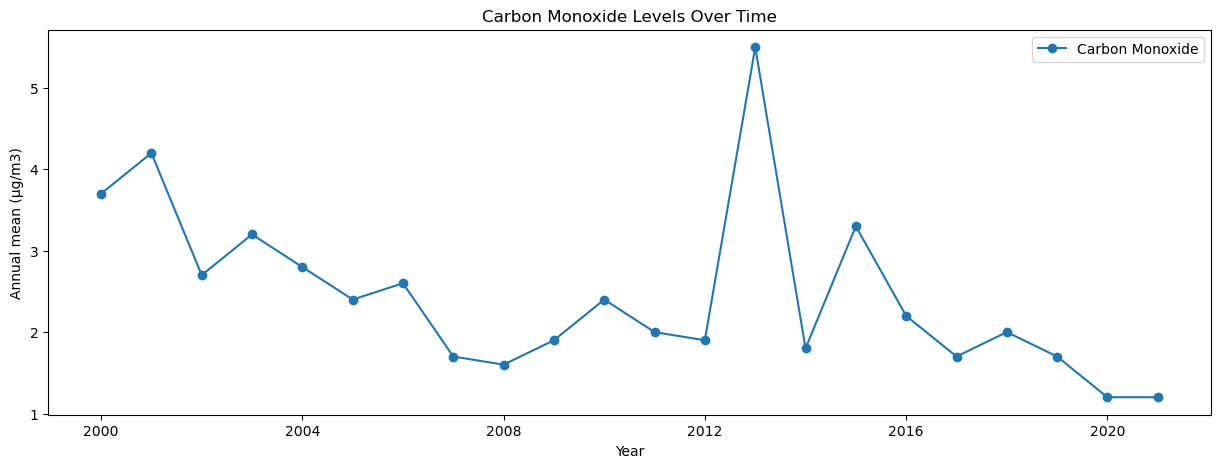

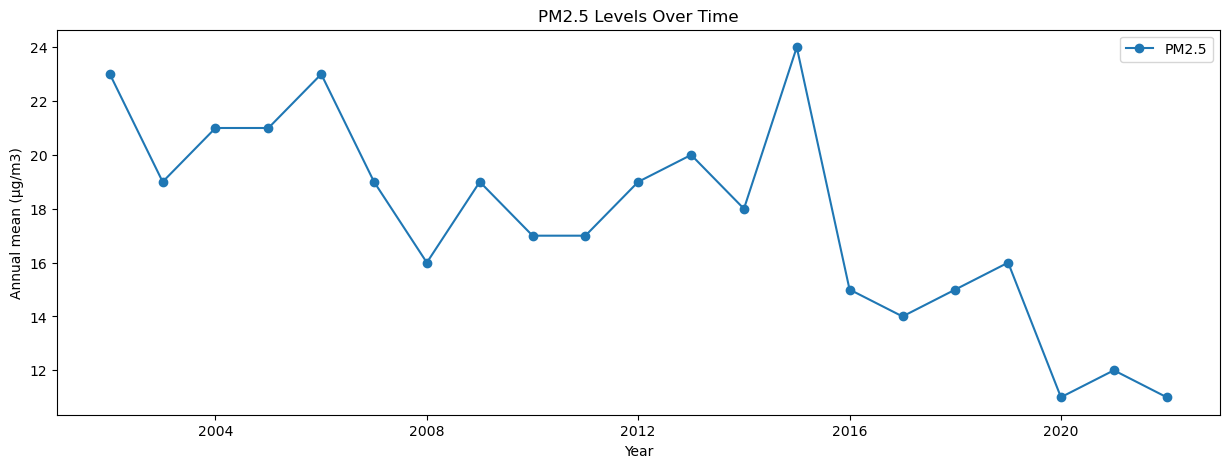

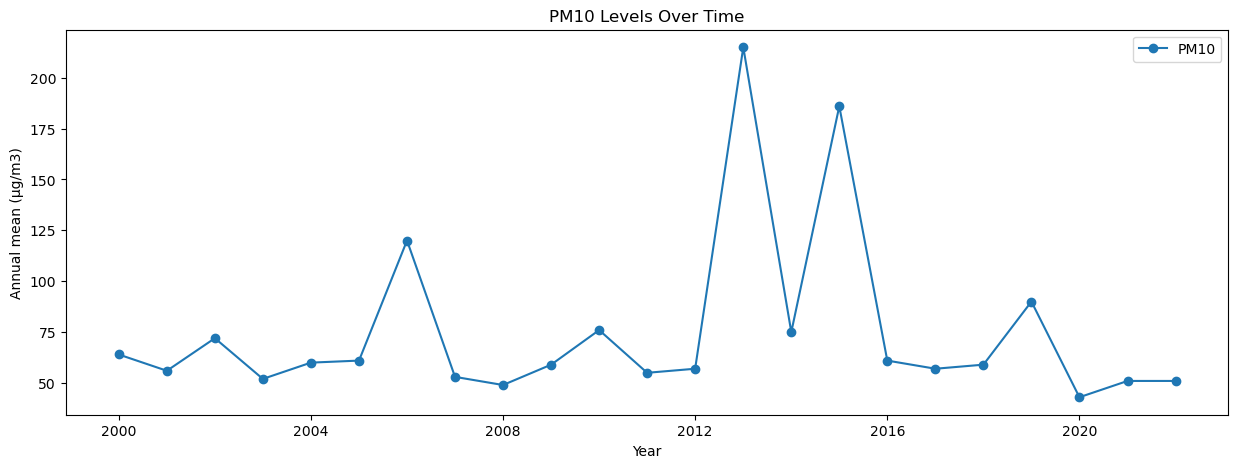

In [6]:

#function for visualizing time series plot for CO, PM2.5, and PM10 levels
# Assuming 'date' is a common column and has been parsed as datetime object, and
# 'value' column represents the pollutant value in each dataset
def plot_pollutant(df, pollutant_name, value_column_name):
    plt.figure(figsize=(15, 5))
    plt.plot(df['year'], df[value_column_name], marker='o', label=pollutant_name)
    plt.title(f'{pollutant_name} Levels Over Time')
    plt.xlabel('Year')
    plt.ylabel('Annual mean (µg/m3)')
    plt.legend()
    plt.show()

# Plot data for each pollutant
plot_pollutant(co_df, 'Carbon Monoxide', 'co_max_8hour_mean')
plot_pollutant(pm25_df, 'PM2.5', 'pm2.5_mean')
plot_pollutant(pm10_df, 'PM10', 'pm10_24hour_mean_99th_per')

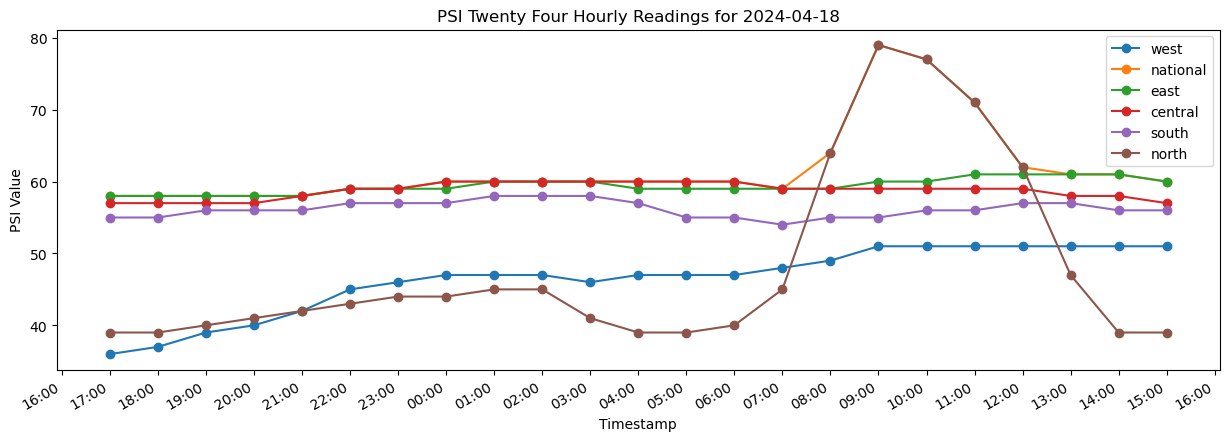

In [27]:
# Main flow invoking function to retrieve data from API 

api_url = "https://api.data.gov.sg/v1/environment/psi?date=2023-04-18"  #We can set this date manually
# Retrieve PSI data from the API
psi_data = fetch_psi_data(api_url)
# Extract relevant data for visualization
psi_df = parse_psi_data(psi_data)
# Plot the PSI data
plot_psi_data(psi_df)